# StyleCLIP 구현하기

**Reference**


*   StyleCLIP 논문: [StyleCLIP: Text-Driven Manipulation of StyleGAN Imagery](https://arxiv.org/abs/2103.17249)
*   [동빈나 - StyleCLIP Tutorial](https://github.com/ndb796/StyleCLIP-Tutorial)



**런타임 유형 GPU로 바꾸기!**

## Install CLIP

**Github에 있는 CLIP 패키지 설치하기**



*   Github에 있는 패키지 설치하기: pip install git+https://



In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 64 kB 2.4 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=ad91ec0727ac5e770d06d196c331d0808b7acea2b745dc53f364f6433b116555
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_l4jd4ks
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-_l4jd4ks
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369106 sha256=0a484988fc2fc07ed50fdbb7a161c741fcd1747f20742b21bf66d84f32f3b957
  Stored in directory: /tmp/pip-ephem-wheel-cache-fxxuye55/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


## Load the Pre-trained StyleGAN Model

**사전 학습된 StyleGAN 모델 다운 받기**



*   Github에 있는 오픈소스 내 컴퓨터로 가져오기(Git 저장소 복제하기): git clone [REPO_URL] [DIR]

  - [REPO_URL]: 클론해올 저장소의 주소
  - [DIR]: 저장소를 로컬에 복제할 위치를 저장. 생략가능하다.

*    cd [ 디렉토리 경로]: 이동하려는 디렉토리로 이동



In [2]:
!git clone https://github.com/ndb796/StyleCLIP-Tutorial
%cd StyleCLIP-Tutorial

Cloning into 'StyleCLIP-Tutorial'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 19), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (64/64), done.
/content/StyleCLIP-Tutorial


**모델 가중치 파일 다운로드하기**



*   인터넷 상의 파일 다운로드 받기: wget [Download - URL]
*   stylegan2-ffhq-config-f.pt: 사전 학습된 StyleGAN2 모델의 가중치



In [3]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1 -O stylegan2-ffhq-config-f.pt

--2021-11-25 04:10:49--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EVv6yusEt1tFhrL3TCu0Ta4BlpzW3eBMTS0yTPKodNHsNA?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt [following]
--2021-11-25 04:10:50--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/stylegan2-ffhq-config-f.pt
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 381462551 (364M) [application/octet-stream]
Saving to: ‘stylegan2-ffhq-config-f.pt’

stylegan2-ffhq-conf 100%[===================>] 363.79M  59.1MB/s    in 11s     

2021-11-25 04:11:01 (33.3 MB/s) - ‘

**Generator 모델과 사전 학습된 가중치를 불러온 후 모델 초기화시키기**

* 모델 가중치 저장하고 불러오기: .load_state_dict()
  
  - 모델 가중치를 불러오기 위해서는, 먼저 모델의 인스턴스(instance)를 생성한 다음에 load_state_dict() 메서드를 사용해서 매개변수들을 불러온다.

* strict=False: 모델의 state_dict의 일부만 불러오거나, 적재하려는 모델보다 더 많은 키를 갖고 있는 state_dict를 불러 올때 설정
  - 주로 전이학습을 할 때, 모델의 매개변수 일부만 불러서 사용한다.
* .eval(): 모델을 불러온 후 이 모델을 사용할 경우에 사용한다. (학습할 경우에는 model.train())
  - 학습할 때만 사용하는 개념인 Dropout이나 Batchnorm 등을 비활성화시킨다. 즉, evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시켜주는 함수이다.


In [4]:
import torch
from stylegan2.model import Generator

g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()

## CLIP Loss

**CLIP Loss 정의하기**

* CLIPLoss 클래스는 torch.nn.Module을 상속받는다.
* super().__ init __(): super()를 사용해서 기반 클래스(torch.nn.Module)의 메서드를 호출해준다.
* def forward(self, image, text): image와 text를 입력으로 받아 유사도를 계산하고, 그 값을 반환한다.

In [5]:
import clip

class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

## Latent Optimization

**mean latent vector를 사용하여 random latent vector 초기화하기**

* 하나의 random latent vector를 만든다.
* mean_latent: latent vector 업데이트 시 기준으로 삼을 평균치를 갖는 latent 생성
* truncation 트릭: 특정한 latent vector가 평균 latent vector로부터 크게 벗어나지 않도록 latent를 잘라내 준다.
  - 약 0.7 정도로 설정할 때, 매우 그럴싸한 랜덤 이미지를 만들 수 있다.
* with torch.no_grad(): Pytorch의 autograd engine을 꺼서 메모리 사용량을 줄이고, 연산 속도를 높여준다.
* 우리가 사용하고 있는 사전 학습된 StyleGAN 모델은 1024x1024의 고해상도 이미지를 만들어내기 때문에 너비와 높이를 1/2씩 줄여서 * 화면에 간단히 출력해본다.
random vector로 생성하기 때문에 코드를 실행할 때마다 랜덤한 이미지를 얻을 수 있다

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


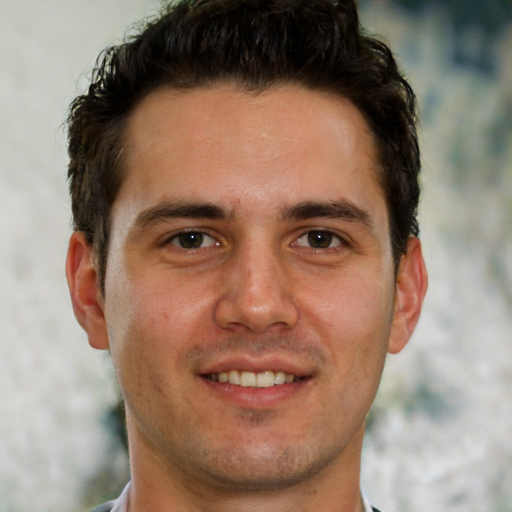

In [24]:
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage

mean_latent = g_ema.mean_latent(4096)

latent_code_init_not_trunc = torch.randn(1, 512).cuda()
with torch.no_grad():
    img_orig, latent_code_init = g_ema([latent_code_init_not_trunc], return_latents=True,
                                truncation=0.7, truncation_latent=mean_latent)

# Visualize a random latent vector.
image = ToPILImage()(make_grid(img_orig.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = image.size
image.resize((h // 2, w // 2))

**파라미터 설정하기**

* 가장 중요한 2가지: description과 l2_lambda
  * description: 이미지를 manipulation할 때 입력할 text prompt
  * l2_lambda: 가중치 파라미터
    - 값이 커질수록 원본 이미지와 유사해지려고 한다.
    - 값이 작을수록 text prompt와 높은 similarity를 갖게 된다

In [8]:
from argparse import Namespace

args = Namespace()
args.description = 'A really sad face'
args.lr_rampup = 0.05
args.lr = 0.1
args.step = 150
args.l2_lambda = 0.005 # The weight for similarity to the original image.
args.save_intermediate_image_every = 1
args.results_dir = 'results'

**latent vector를 최적화시키고, 결과 얻기**



*   The learning rate adjustment function
  - earning rate을 각 스텝마다 적절히 조정해서 적용할 수 있도록 한다.
  - 즉, 고정된 특정한 learning rate만 사용하는 것이 아니라 스탭이 반복될 때 learning rate를 적절히 조정해 optimization을 보다 매끄럽게 수행할 수 있도록 한다.



In [9]:
import os
import math
import torchvision
from torch import optim

# The learning rate adjustment function.
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp



*   우리가 입력한 description(args.description)은 먼저 토큰화된 이후에 CLIP 인코더에 들어갈 수 있게 된다.



In [10]:
text_inputs = torch.cat([clip.tokenize(args.description)]).cuda()
os.makedirs(args.results_dir, exist_ok=True)

* Initialize the latent vector to be updated
  - Adam optimizer를 이용해서 latent vector 업데이트한다.

In [25]:
# Initialize the latent vector to be updated.
latent = latent_code_init.detach().clone()
latent.requires_grad = True

clip_loss = CLIPLoss()
optimizer = optim.Adam([latent], lr=args.lr)

* 각각의 스탭마다 위 코드가 반복적으로 수행된다.
* 먼저 learning rate를 조정한 뒤에 latent vector를 이용해서 이미지를 생성한다.
* 생성한 이미지와 우리가 입력한 text prompt가 높은 similarity를 갖도록 업데이트 해준다.
* 그와 동시에 초기 latent vector와도 유사하도록, 즉 원본 이미지를 유지하도록 latent vactor를 제한하는 l2_loss를 넣어준다.
* 이 두 가지 loss를 이용해 latent vector를 optimization한다.
* 이 loss를 기반으로 역전파를 수행한 뒤에 그레디언트를 구해선 latent vector를 업데이트 한다.
* 구글 Colab환경에서 약 2~3분 정도 소요된다.

In [26]:
for i in range(args.step):
    # Adjust the learning rate.
    t = i / args.step
    lr = get_lr(t, args.lr)
    optimizer.param_groups[0]["lr"] = lr

    # Generate an image using the latent vector.
    img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)

    # Calculate the loss value.
    c_loss = clip_loss(img_gen, text_inputs)
    l2_loss = ((latent_code_init - latent) ** 2).sum()
    loss = c_loss + args.l2_lambda * l2_loss

    # Get gradient and update the latent vector.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Log the current state.
    print(f"lr: {lr}, loss: {loss.item():.4f}")
    if args.save_intermediate_image_every > 0 and i % args.save_intermediate_image_every == 0:
        with torch.no_grad():
            img_gen, _ = g_ema([latent], input_is_latent=True, randomize_noise=False)
        torchvision.utils.save_image(img_gen, f"results/{str(i).zfill(5)}.png", normalize=True, range=(-1, 1))

with torch.no_grad():
    img_orig, _ = g_ema([latent_code_init], input_is_latent=True, randomize_noise=False)

# Display the initial image and result image.
final_result = torch.cat([img_orig, img_gen])
torchvision.utils.save_image(final_result.detach().cpu(), os.path.join(args.results_dir, "final_result.jpg"), normalize=True, scale_each=True, range=(-1, 1))

lr: 0.0, loss: 0.7876


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


lr: 0.013333333333333334, loss: 0.7876
lr: 0.02666666666666667, loss: 0.7793
lr: 0.04, loss: 0.7856
lr: 0.05333333333333334, loss: 0.8071
lr: 0.06666666666666667, loss: 0.8164
lr: 0.08, loss: 0.8174
lr: 0.09333333333333334, loss: 0.8091
lr: 0.1, loss: 0.8032
lr: 0.1, loss: 0.7974
lr: 0.1, loss: 0.7881
lr: 0.1, loss: 0.7998
lr: 0.1, loss: 0.8203
lr: 0.1, loss: 0.8237
lr: 0.1, loss: 0.8418
lr: 0.1, loss: 0.8359
lr: 0.1, loss: 0.8271
lr: 0.1, loss: 0.8184
lr: 0.1, loss: 0.8037
lr: 0.1, loss: 0.7910
lr: 0.1, loss: 0.7842
lr: 0.1, loss: 0.7788
lr: 0.1, loss: 0.7739
lr: 0.1, loss: 0.7676
lr: 0.1, loss: 0.7690
lr: 0.1, loss: 0.7686
lr: 0.1, loss: 0.7666
lr: 0.1, loss: 0.7646
lr: 0.1, loss: 0.7598
lr: 0.1, loss: 0.7549
lr: 0.1, loss: 0.7539
lr: 0.1, loss: 0.7578
lr: 0.1, loss: 0.7583
lr: 0.1, loss: 0.7524
lr: 0.1, loss: 0.7490
lr: 0.1, loss: 0.7520
lr: 0.1, loss: 0.7539
lr: 0.1, loss: 0.7544
lr: 0.1, loss: 0.7524
lr: 0.1, loss: 0.7505
lr: 0.1, loss: 0.7534
lr: 0.1, loss: 0.7534
lr: 0.1, loss: 

## Result Visualization

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


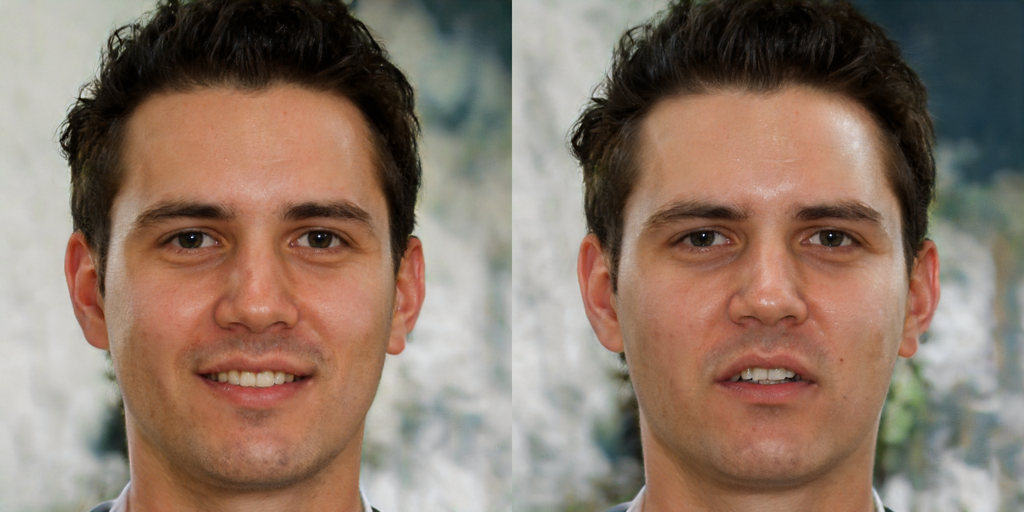

In [27]:
result_image = ToPILImage()(make_grid(final_result.detach().cpu(), normalize=True, scale_each=True, range=(-1, 1), padding=0))
h, w = result_image.size
result_image.resize((h // 2, w // 2))



*   이미지가 서서히 변화하는 과정을 담은 몰핀 비디오 또한 다운받을 수 있다. 총 150번의 스탭을 반복했기 때문에 150프레임으로 구성된 동영상을 생성하여 다운로드 할 수 있다.



In [28]:
!ffmpeg -r 15 -i results/%05d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4

from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>